In [1]:
# Copyright © 2020, Johan Vonk
# SPDX-License-Identifier: MIT

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import paho.mqtt.client as mqtt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_addons as tfa
from scipy.interpolate import interp1d
from scipy.stats import lognorm, exponnorm
from scipy.ndimage.filters import gaussian_filter1d

In [3]:
np.random.seed(0)

In [4]:
df=pd.read_csv('pact_20200713T230751.csv')

In [5]:
df['TIMESTAMP']=pd.to_datetime(df['TIMESTAMP'],'coerce')
df['RSSI']=pd.to_numeric(df['RSSI'],'coerce')

In [18]:
df['RELATIVE']=pd.to_numeric(df['SCANNER'].str.replace("esp32-",""))-pd.to_numeric(df['ADVERTISER'].str.replace("esp32-",""))

In [187]:
df['S']=pd.to_numeric(df['SCANNER'].str.replace("esp32-",""))
df['A']=pd.to_numeric(df['ADVERTISER'].str.replace("esp32-",""))

ValueError: x and y must have same first dimension, but have shapes (174,) and (16,)

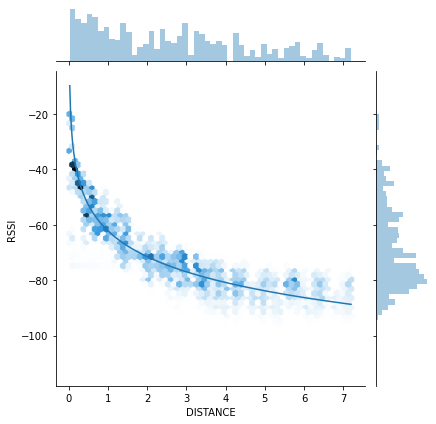

In [147]:
g=sns.jointplot(x="DISTANCE", y="RSSI", data=df, kind="hex", joint_kws=dict(gridsize=50))
x=np.array(sorted(df['DISTANCE'].unique()))
g.ax_joint.plot(x,distance_to_RSSI(x),label='Estimated')
g.ax_joint.plot(x,other.groupby('DISTANCE')['RSSI'].mean(),label='Mean measured')
g.ax_joint.set_xlabel('Distance (m)')
g.ax_joint.set_ylabel('RSSI (dBm)')
g.ax_joint.legend(loc="upper left")
plt.show()

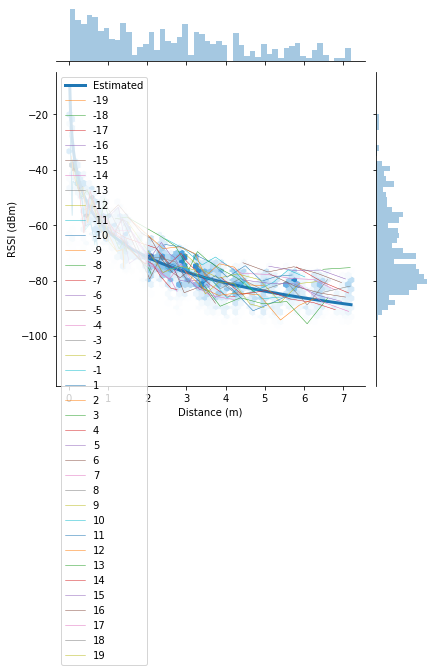

In [183]:
g=sns.jointplot(x="DISTANCE", y="RSSI", data=df, kind="hex", joint_kws=dict(gridsize=50))
x=np.array(sorted(df['DISTANCE'].unique()))
g.ax_joint.plot(x,distance_to_RSSI(x),linewidth=3,label='Estimated')
data=df.groupby(['RELATIVE','DISTANCE'])['RSSI'].mean()
for relative in sorted(df['RELATIVE'].unique()):
    x=np.array(sorted(data[relative].index))
    g.ax_joint.plot(x,data[relative]+np.mean(data[relative]-distance_to_RSSI(data[relative].index)),linewidth=0.5,label=relative)
g.ax_joint.set_xlabel('Distance (m)')
g.ax_joint.set_ylabel('RSSI (dBm)')
g.ax_joint.legend(loc="upper left")
plt.show()

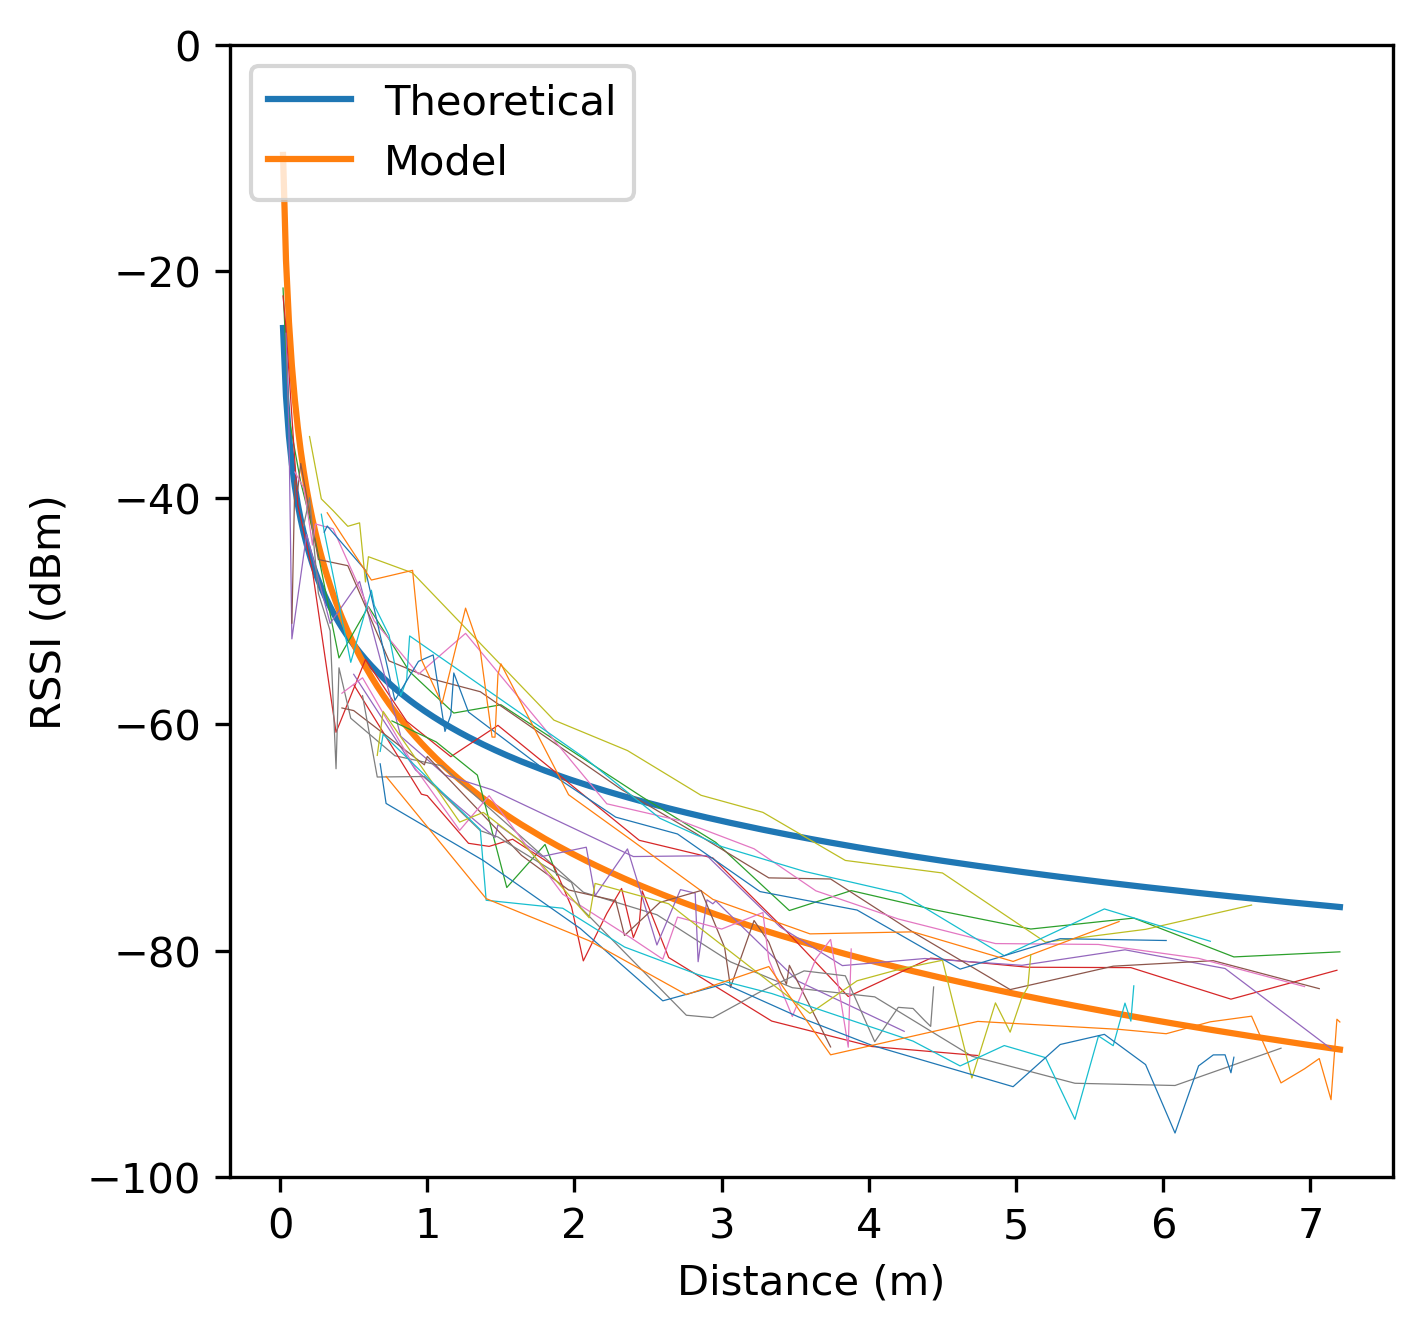

In [256]:
x=np.array(sorted(df['DISTANCE'].unique()))
fig=plt.gcf()
plt.plot(x,-59.0-np.log10(x)*20.0,label='Theoretical')
plt.plot(x,distance_to_RSSI(x),label='Model')
data=df.groupby(['S','DISTANCE'])['RSSI'].mean()
for relative in sorted(df['S'].unique()):
    x=np.array(sorted(data[relative].index))
    plt.plot(x,data[relative]+np.mean(data[relative]-distance_to_RSSI(data[relative].index)),linewidth=0.3)
plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dBm)')
plt.legend(loc="upper left")
fig.set_size_inches(5,5)
plt.ylim(-100,0)
plt.savefig('rssi-vs-scanner.png',dpi=300)
fig.set_dpi(300)
plt.show()

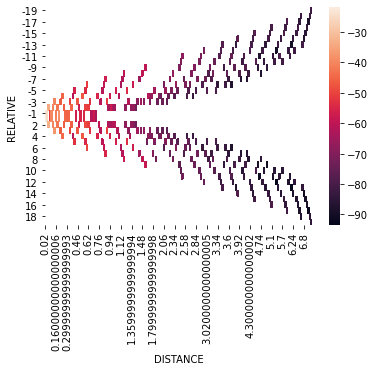

In [137]:
data=df.groupby(['RELATIVE','DISTANCE'])['RSSI'].mean().unstack()
sns.heatmap(data)

In [100]:
data

DISTANCE,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,0.20,...,6.42,6.46,6.48,6.60,6.80,6.96,7.06,7.14,7.18,7.20
RELATIVE,,,,,,,,,,,,,,,,,,,,,
-19,-81.664089,-81.664089,-81.664089,-81.664089,-81.664089,-81.664089,-81.664089,-81.664089,-81.664089,-81.664089,...,-81.664089,-81.664089,-81.664089,-81.664089,-81.664089,-81.664089,-81.664089,-81.664089,-81.664089,-81.664089
-18,-82.112821,-82.112821,-82.112821,-82.112821,-82.112821,-82.112821,-82.112821,-82.112821,-82.112821,-82.112821,...,-82.112821,-82.112821,-82.112821,-82.112821,-82.112821,-82.112821,-82.112821,-82.112821,-81.522321,-81.522321
-17,-78.683388,-78.683388,-78.683388,-78.683388,-78.683388,-78.683388,-78.683388,-78.683388,-78.683388,-78.683388,...,-78.683388,-84.075232,-84.075232,-84.075232,-84.075232,-84.075232,-84.075232,-88.112084,-88.112084,-88.112084
-16,-79.650045,-79.650045,-79.650045,-79.650045,-79.650045,-79.650045,-79.650045,-79.650045,-79.650045,-79.650045,...,-81.034054,-81.034054,-81.034054,-81.034054,-81.034054,-81.034054,-84.247756,-84.247756,-84.247756,-84.247756
-15,-77.933923,-77.933923,-77.933923,-77.933923,-77.933923,-77.933923,-77.933923,-77.933923,-77.933923,-77.933923,...,-81.777473,-81.777473,-81.777473,-81.777473,-81.777473,-85.105911,-85.105911,-85.105911,-85.105911,-85.105911
-14,-76.258254,-76.258254,-76.258254,-76.258254,-76.258254,-76.258254,-76.258254,-76.258254,-76.258254,-76.258254,...,-82.612831,-82.612831,-82.612831,-82.612831,-86.426891,-86.426891,-86.426891,-86.426891,-86.426891,-86.426891
-13,-78.016378,-78.016378,-78.016378,-78.016378,-78.016378,-78.016378,-78.016378,-78.016378,-78.016378,-78.016378,...,-89.718571,-89.718571,-89.718571,-80.568110,-80.568110,-80.568110,-80.568110,-80.568110,-80.568110,-80.568110
-12,-71.997706,-71.997706,-71.997706,-71.997706,-71.997706,-71.997706,-71.997706,-71.997706,-71.997706,-71.997706,...,-82.063247,-82.063247,-82.063247,-82.063247,-82.063247,-82.063247,-82.063247,-82.063247,-82.063247,-82.063247
-11,-67.988933,-67.988933,-67.988933,-67.988933,-67.988933,-67.988933,-67.988933,-67.988933,-67.988933,-67.988933,...,-81.746575,-81.746575,-81.746575,-81.746575,-81.746575,-81.746575,-81.746575,-81.746575,-81.746575,-81.746575


In [65]:
data.rolling

In [54]:
help(sns.heatmap)

Help on function heatmap in module seaborn.matrix:

heatmap(data, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)
    Plot rectangular data as a color-encoded matrix.
    
    This is an Axes-level function and will draw the heatmap into the
    currently-active Axes if none is provided to the ``ax`` argument.  Part of
    this Axes space will be taken and used to plot a colormap, unless ``cbar``
    is False or a separate Axes is provided to ``cbar_ax``.
    
    Parameters
    ----------
    data : rectangular dataset
        2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
        is provided, the index/column information will be used to label the
        columns and rows.
    vmin, vmax : floats, optional
        Values to anchor the colormap, otherwise the

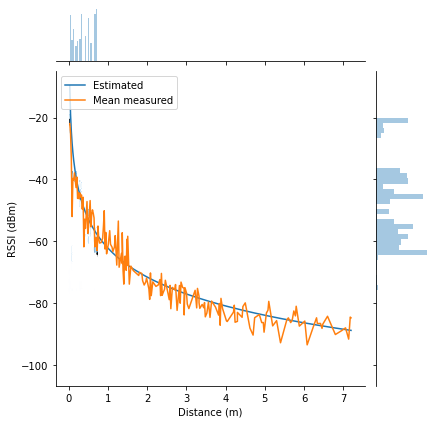

In [243]:
g=sns.jointplot(x="DISTANCE", y="RSSI", data=other, kind="hex", joint_kws=dict(gridsize=50))
x=np.array(sorted(infront['DISTANCE'].unique()))
g.ax_joint.plot(x,distance_to_RSSI(x),label='Estimated')
g.ax_joint.plot(x,infront.groupby('DISTANCE')['RSSI'].mean(),label='Mean measured')
g.ax_joint.set_xlabel('Distance (m)')
g.ax_joint.set_ylabel('RSSI (dBm)')
g.ax_joint.legend(loc="upper left")
g.ax_joint.set_ylim(-100,0)
plt.show()

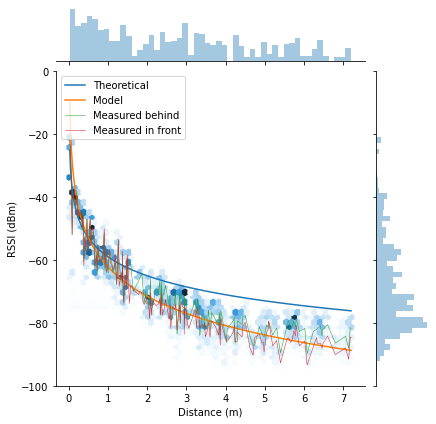

In [244]:
g=sns.jointplot(x="DISTANCE", y="RSSI", data=behind, kind="hex", joint_kws=dict(gridsize=50))
x=np.array(sorted(df['DISTANCE'].unique()))
g.ax_joint.plot(x,-59.0-np.log10(x)*20.0,label='Theoretical')
g.ax_joint.plot(x,distance_to_RSSI(x),label='Model')
g.ax_joint.plot(np.array(sorted(behind['DISTANCE'].unique())),behind.groupby('DISTANCE')['RSSI'].mean(),linewidth=0.5,label='Measured behind')
g.ax_joint.plot(np.array(sorted(infront['DISTANCE'].unique())),infront.groupby('DISTANCE')['RSSI'].mean(),linewidth=0.5,label='Measured in front')
g.ax_joint.set_xlabel('Distance (m)')
g.ax_joint.set_ylabel('RSSI (dBm)')
g.ax_joint.legend(loc="upper left")
g.ax_joint.set_ylim(-100,0)
plt.savefig('rssi_vs_distance.png',dpi=300)

In [6]:
compare=df.groupby([pd.to_numeric(df['SCANNER'].str.replace("esp32-","")),
            pd.to_numeric(df['ADVERTISER'].str.replace("esp32-",""))]).mean()

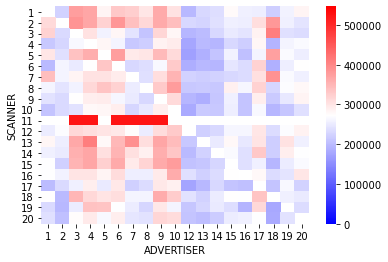

In [7]:
sns.heatmap(compare['Unnamed: 0'].unstack(),cmap='bwr',center=len(df)/2,vmin=0,vmax=len(df))

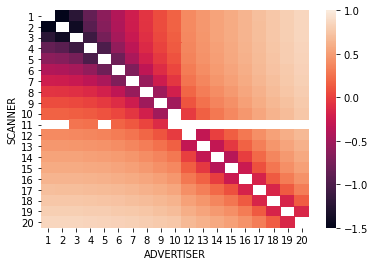

In [8]:
ax=sns.heatmap(np.log10(compare['DISTANCE']).unstack(), vmin=-1.5, vmax=1)

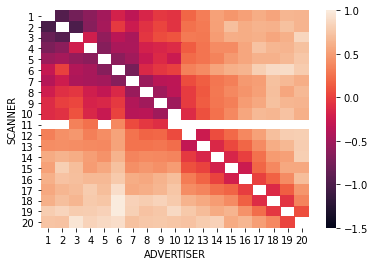

In [9]:
ax=sns.heatmap(np.log10(compare['LOG_PREDICTION']).unstack(), vmin=-1.5, vmax=1)

In [10]:
@tf.custom_gradient
def scaled_swish(features):
    scale=tf.constant(1.78718727865)
    diff=tf.constant(0.20662096414)
    sigmoid_features = tf.math.sigmoid(features)
    @tf.function
    def grad(dy):
        activation_grad = (sigmoid_features * (1 + features * (1 - sigmoid_features))) * scale
        return dy * activation_grad
    return (features * tf.math.sigmoid(features)-diff) * scale, grad

In [11]:
samples=20
batch_size=32
epochs={0.5:63,0.25:15,0.75:15,0.1:15,0.9:15}
steps_per_epoch=10000
initial_lr=0.00005
epochs_per_restart=1
wd_coefficient=0.2
quantiles=[0.50,0.25,0.75,0.1,0.9]
load_from={0.50:None,0.25:0.5,0.75:0.5,0.1:0.25,0.9:0.75}
alpha=0.45
grid_size=10
activation=scaled_swish
initializer=tf.keras.initializers.lecun_normal()

In [7]:
lognormdist=lambda m,v: (lambda x: np.exp(x*np.sqrt(math.log(1+(v/m)**2))+math.log(m**2/np.sqrt(m**2+v**2))))
normdist=lambda m,v: (lambda x: x*v+m)
modes=[normdist(0.0,0.0),    # not moving
       lognormdist(4.4,7.0), # bike
       normdist(1.35,0.25),  # walk
       lognormdist(2.7,1.1)] # run
p=np.array([[0.48,0.03,0.09,0.02],
            [0.01,0.04,0.02,0.01],
            [0.02,0.02,0.14,0.04],
            [0.01,0.01,0.04,0.02]])
speed_data=lambda n:np.concatenate([
                        np.concatenate([np.abs(mode1(np.random.randn(x))+
                                               mode2(np.random.randn(x))*np.random.choice(a=[-1,1],p=[0.4,0.6],size=x))
                        for x, mode2 in zip(row,modes)])
                    for row, mode1 in zip((p*n).astype(int),modes)])
RSSI_var=lambda n: exponnorm.rvs(K=0.469, loc=-2.308, scale=4.904, size=(n,samples))
RSSI_to_distance=lambda x:10**((-62.235-x)/30.9)
distance_to_RSSI=lambda x:-62.235-np.log10(x)*30.9
start_RSSI_var=lambda n:exponnorm.rvs(size=n, K=0.469, loc=95, scale=2)
closest_var=lambda n:np.repeat(np.concatenate([lognormdist(3.5,1.0)(np.random.randn(n//4)),lognormdist(1.625,8.0)(np.random.randn(n*3//4))])[None],samples,0).T
def distance(n):
    deltas=-0.15*speed_data(n)
    np.random.shuffle(deltas)
    distance_starts=RSSI_to_distance(start_RSSI_var(n))
    starts=-distance_starts+np.random.randn(n)*deltas/2+deltas*5
    ends=distance_starts-np.random.randn(n)*deltas/2-deltas*5
    centers=np.random.uniform(starts,ends,starts.shape)
    centers[deltas==0]=ends[deltas==0]
    return np.sqrt(np.square(np.abs(np.linspace(centers-deltas*5,centers+deltas*5,samples)).T)+np.square(closest_var(n)))
distance_var=lambda x:RSSI_to_distance(distance_to_RSSI(x)+RSSI_var(x.shape[0]))

def generate_data(batch_size):
    group_size = 100 # must be multiple of 100 so probabilities divide evenly
    while True:
        y=distance(batch_size*group_size)
        x=distance_var(y)
        for i in range(0, batch_size*group_size, batch_size):
            yield x[i:i+batch_size], y[i:i+batch_size]

In [14]:
y_test=distance(steps_per_epoch*10)
x_test=distance_var(y_test)

In [15]:
step = tf.Variable(0, trainable=False)
schedule=tf.keras.experimental.CosineDecayRestarts(initial_lr,steps_per_epoch*epochs_per_restart,alpha=alpha)
lr = schedule(step)
wd = wd_coefficient * schedule(step)

In [16]:
class LearningRateTracker(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        logs['lr']=K.eval(schedule(steps_per_epoch*(epoch+1)-1))

In [17]:
models={}

In [18]:
for quantile in quantiles:
    models[quantile] = dict()
    model = Sequential(name=str(quantile))
    model.add(Dense(samples*4, kernel_initializer=initializer, activation=activation,input_shape=(samples,)))
    model.add(Dense(samples*3, kernel_initializer=initializer, activation=activation))
    model.add(Dense(samples*2, kernel_initializer=initializer, activation=activation))
    model.add(Dense(samples, kernel_initializer=initializer, activation=activation))
    model.compile(loss=tfa.losses.PinballLoss(tau=quantile),
              optimizer=tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd, amsgrad=True))
    if load_from[quantile]:
        model.load_weights(f'model-rssi-line-{load_from[quantile]}.hdf5')
    model.summary()
    history = model.fit(generate_data(batch_size), validation_data=(x_test,y_test), epochs=epochs[quantile], batch_size=batch_size, steps_per_epoch=steps_per_epoch, verbose=0, callbacks=[LearningRateTracker(),tfa.callbacks.TQDMProgressBar(metrics_format="{name} : {value:0.6g}",update_per_second=1)])
    model.save(f'model-rssi-line-{quantile}.hdf5')
    models[quantile]['model']=model
    models[quantile]['history']=history
    models[quantile]['p_test']=model.predict(x_test)

Model: "0.5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                1680      
_________________________________________________________________
dense_1 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                820       
Total params: 9,800
Trainable params: 9,800
Non-trainable params: 0
_________________________________________________________________


Epoch 1/63



Epoch 2/63



Epoch 3/63



Epoch 4/63



Epoch 5/63



Epoch 6/63



Epoch 7/63



Epoch 8/63



Epoch 9/63



Epoch 10/63



Epoch 11/63



Epoch 12/63



Epoch 13/63



Epoch 14/63



Epoch 15/63



Epoch 16/63



Epoch 17/63



Epoch 18/63



Epoch 19/63



Epoch 20/63



Epoch 21/63



Epoch 22/63



Epoch 23/63



Epoch 24/63



Epoch 25/63



Epoch 26/63



Epoch 27/63



Epoch 28/63



Epoch 29/63



Epoch 30/63



Epoch 31/63



Epoch 32/63



Epoch 33/63



Epoch 34/63



Epoch 35/63



Epoch 36/63



Epoch 37/63



Epoch 38/63



Epoch 39/63



Epoch 40/63



Epoch 41/63



Epoch 42/63



Epoch 43/63



Epoch 44/63



Epoch 45/63



Epoch 46/63



Epoch 47/63



Epoch 48/63



Epoch 49/63



Epoch 50/63



Epoch 51/63



Epoch 52/63



Epoch 53/63



Epoch 54/63



Epoch 55/63



Epoch 56/63



Epoch 57/63



Epoch 58/63



Epoch 59/63



Epoch 60/63



Epoch 61/63



Epoch 62/63



Epoch 63/63




Model: "0.25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_5 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_6 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_7 (Dense)              (None, 20)                820       
Total params: 9,800
Trainable params: 9,800
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15



Epoch 2/15



Epoch 3/15



Epoch 4/15



Epoch 5/15



Epoch 6/15



Epoch 7/15



Epoch 8/15



Epoch 9/15



Epoch 10/15



Epoch 11/15



Epoch 12/15



Epoch 13/15



Epoch 14/15



Epoch 15/15




Model: "0.75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_9 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_10 (Dense)             (None, 40)                2440      
_________________________________________________________________
dense_11 (Dense)             (None, 20)                820       
Total params: 9,800
Trainable params: 9,800
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15



Epoch 2/15



Epoch 3/15



Epoch 4/15



Epoch 5/15



Epoch 6/15



Epoch 7/15



Epoch 8/15



Epoch 9/15



Epoch 10/15



Epoch 11/15



Epoch 12/15



Epoch 13/15



Epoch 14/15



Epoch 15/15




Model: "0.1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 80)                1680      
_________________________________________________________________
dense_13 (Dense)             (None, 60)                4860      
_________________________________________________________________
dense_14 (Dense)             (None, 40)                2440      
_________________________________________________________________
dense_15 (Dense)             (None, 20)                820       
Total params: 9,800
Trainable params: 9,800
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15



Epoch 2/15



Epoch 3/15



Epoch 4/15



Epoch 5/15



Epoch 6/15



Epoch 7/15



Epoch 8/15



Epoch 9/15



Epoch 10/15



Epoch 11/15



Epoch 12/15



Epoch 13/15



Epoch 14/15



Epoch 15/15




Model: "0.9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 80)                1680      
_________________________________________________________________
dense_17 (Dense)             (None, 60)                4860      
_________________________________________________________________
dense_18 (Dense)             (None, 40)                2440      
_________________________________________________________________
dense_19 (Dense)             (None, 20)                820       
Total params: 9,800
Trainable params: 9,800
Non-trainable params: 0
_________________________________________________________________


Epoch 1/15



Epoch 2/15



Epoch 3/15



Epoch 4/15



Epoch 5/15



Epoch 6/15



Epoch 7/15



Epoch 8/15



Epoch 9/15



Epoch 10/15



Epoch 11/15



Epoch 12/15



Epoch 13/15



Epoch 14/15



Epoch 15/15


(0.05, 0.15)

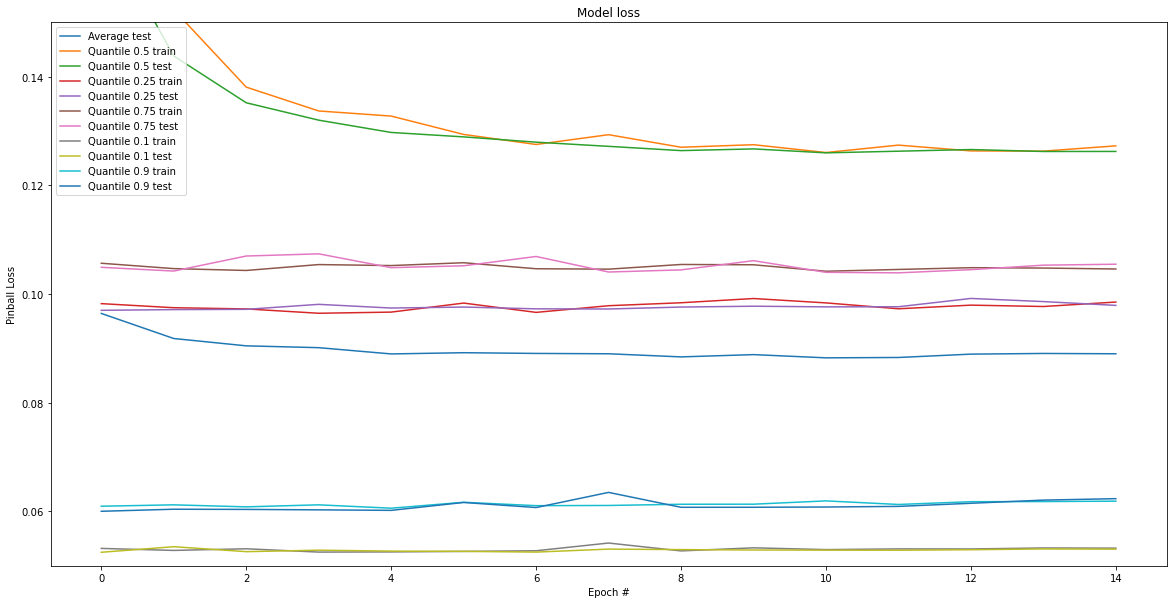

In [23]:
plt.rcParams["figure.figsize"] = (20,10)
data=np.mean(np.vstack([models[quantile]['history'].history['val_loss'][:15] for quantile in quantiles if quantile in models and 'history' in models[quantile]]),axis=0)
plt.plot(data,label='Average test')
for quantile in quantiles:
    if quantile in models and 'history' in models[quantile]:
        plt.plot(models[quantile]['history'].history['loss'][:15],label='Quantile '+str(quantile)+' train')
        plt.plot(models[quantile]['history'].history['val_loss'][:15],label='Quantile '+str(quantile)+' test')
plt.title('Model loss')
plt.ylabel('Pinball Loss')
plt.xlabel('Epoch #')
plt.legend(loc='upper left')
plt.ylim(0.05,0.15)

Text(0.5, 0, 'Epoch #')

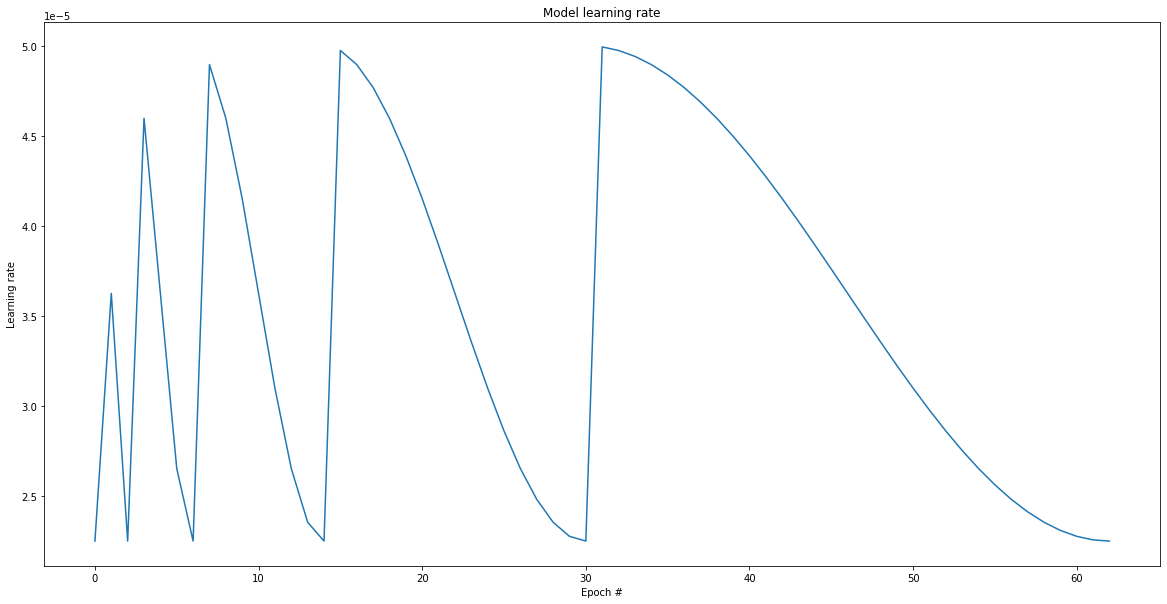

In [24]:
plt.plot(models[quantiles[0]]['history'].history['lr'])
plt.title('Model learning rate')
plt.ylabel('Learning rate')
plt.xlabel('Epoch #')

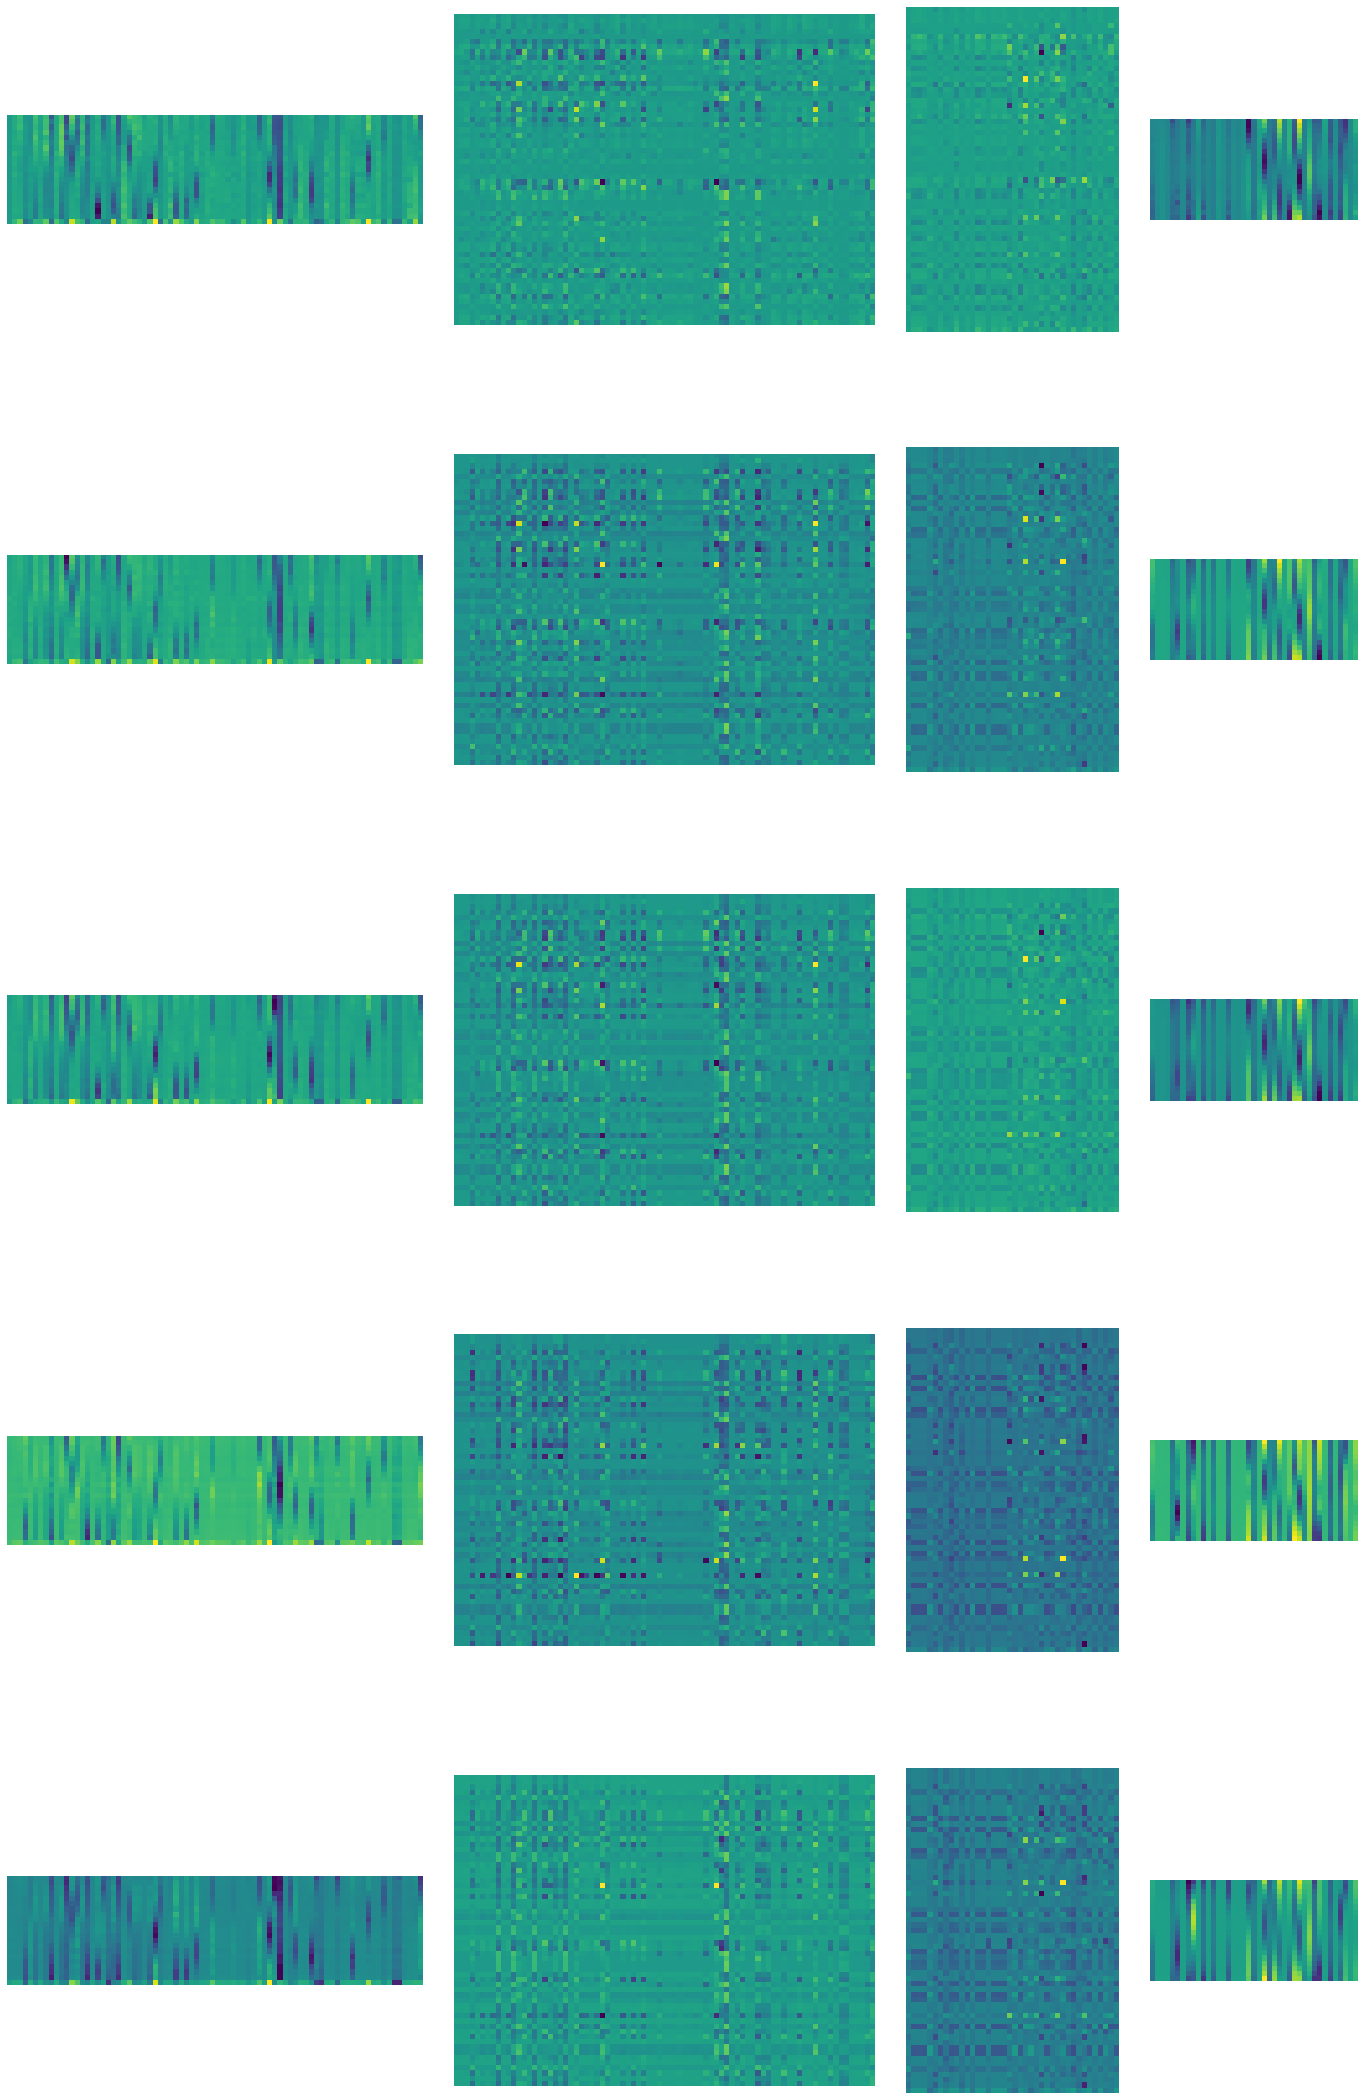

In [25]:
weights_arr={}
for quantile in quantiles:
    weights_arr[quantile]=[]
    for layer in models[quantile]['model'].layers:
        weights_arr[quantile].append(np.vstack(layer.get_weights()))
fig,ax=plt.subplots(len(quantiles),len(weights_arr[quantiles[0]]),gridspec_kw={'width_ratios': [samples*4,samples*4+1,samples*2+1,samples*2]},figsize=(samples*1.2+0.2,(4*samples+1)*len(quantiles)/10))
plt.subplots_adjust(wspace=0.1, hspace=0.00)
plt.margins(0,0)
for q in range(len(quantiles)):
    for i in range(len(weights_arr[quantiles[0]])):
        arr=weights_arr[quantiles[q]][i] if i%2==0 else weights_arr[quantiles[q]][i].T
        ax[q,i].imshow(arr,interpolation='nearest',aspect='equal')
        ax[q,i].axis('off')
        ax[q,i].set_anchor('W')

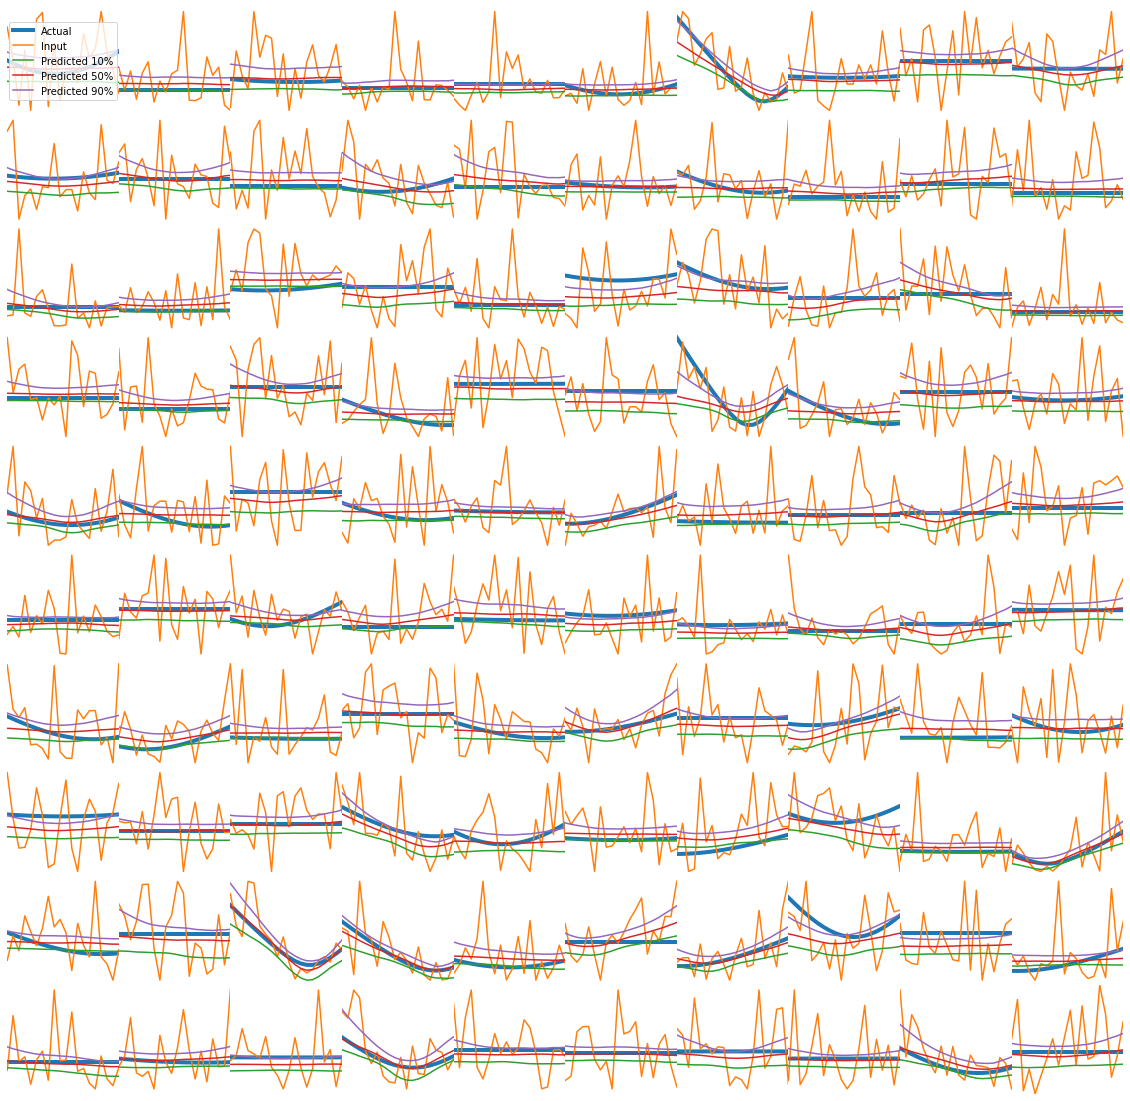

In [26]:
idxs=range(grid_size**2)
fig,ax=plt.subplots(grid_size,grid_size,figsize=(20,20),sharex='all')
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.margins(0,0)
axs=ax.reshape(-1)
for i in idxs:
    axs[i]=sns.lineplot(np.array(range(samples))*0.15,y_test[i],linewidth=4.0,ax=axs[i],label='Actual')
    axs[i]=sns.lineplot(np.array(range(samples))*0.15,x_test[i],ax=axs[i],label='Input')
    for quantile in [0.1,0.5,0.9]:
        axs[i]=sns.lineplot(np.array(range(samples))*0.15,models[quantile]['p_test'][i],ax=axs[i],label=f'Predicted {quantile:.0%}')
    if i>0:
        axs[i].get_legend().remove()
    axs[i].axis('off')